In [ ]:
# conda install -c pytorch pytorch-cpu torchvision

In [57]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils

## Set up sequences of simple cell movements

In [3]:
def create_basic_cell_shift(row):
    '''Create sequence of arrays depicting a cell moving at constant speed
       across a domain, frame by frame'''
    input_arrays = []
    arr = np.zeros((100, 100))
    for i, step in enumerate([11, 12, 13, 14, 15, 16, 17, 18, 19, 20]):
        arr2 = np.copy(arr)
        arr2[row:row+10, step:step+10] = 1
        #plt.pcolormesh(arr2)
        #plt.show()
        #plt.close()
        input_arrays.append(arr2)
        
    input_arrays = np.array(input_arrays)

    return input_arrays

In [4]:
def create_basic_cell_shift_v(column):
    '''Create sequence of arrays depicting a cell moving at constant speed
       across a domain, frame by frame'''
    input_arrays = []
    arr = np.zeros((100, 100))
    for i, step in enumerate([11, 12, 13, 14, 15, 16, 17, 18, 19, 20]):
        arr2 = np.copy(arr)
        arr2[step:step+10, column:column+10] = 1
        #plt.pcolormesh(arr2)
        #plt.show()
        #plt.close()
        input_arrays.append(arr2)
        
    input_arrays = np.array(input_arrays)

    return input_arrays

In [5]:
dataset = []
for row in range(10):
    dataset.append(create_basic_cell_shift(row))
for column in range(10):
    dataset.append(create_basic_cell_shift_v(column))
print(np.shape(dataset))
dataset = np.array(dataset)

(20, 10, 100, 100)


In [6]:
# Convert to torch tensors
tensor = torch.stack([torch.Tensor(i) for i in dataset])
#tensor = tensor.unsqueeze(0) # to add a fake batch dimension as torch.nn only supports inputs that are a mini-batch of samples, not a single sample
print(tensor.shape)
print(tensor.type)

torch.Size([20, 10, 100, 100])
<built-in method type of Tensor object at 0x7f70e1637558>


Create torch dataset and dataloader

In [7]:
#my_dataset = utils.TensorDataset(tensor)
train_loader = utils.DataLoader(tensor, batch_size=1)

In [8]:
for i, data in enumerate(train_loader, 0):
    inputs, labels = data[:,:5], data[:,5]

torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])
torch.Size([1, 10, 100, 100])


In [9]:
dataset3 = []
for column in range(10,20):
    dataset3.append(create_basic_cell_shift_v(column))
    
dataset3 = np.array(dataset3) 
tensor3 = torch.stack([torch.Tensor(i) for i in dataset3])
print(tensor3.shape)

val_loader = utils.DataLoader(tensor3, batch_size=1)

torch.Size([10, 10, 100, 100])


## Create CNN

In [10]:
from torch.autograd import Variable
import torch.nn.functional as F

class CNN6(torch.nn.Module):
    
    def __init__(self):
        self.as_super = super(CNN6, self)
        self.as_super.__init__()

        self.conv_1 = torch.nn.Conv2d(5, 1, kernel_size=13, stride=1, padding=6)
        #self.conv_2 = torch.nn.Conv2d(5, 1, kernel_size=13, stride=1, padding=6)
        
        
    def forward(self, x):
        orig = x
                
        x = self.conv_1(x)
        #x = self.conv_2(x)
        
        return(x)

In [11]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.01):
    
    #Loss function
    loss = torch.nn.MSELoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

# Train model

In [12]:
import time

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data[:,:5], data[:,5]
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data.item() #[0]
            total_train_loss += loss_size.data.item() #[0]
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                #print('n_batches = ', n_batches)
                #print('print_every = ', print_every)
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss, # / print_every, 
                    time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for data in val_loader:
            
            #data = data.type('torch.FloatTensor')
            inputs, labels = data[:,:5], data[:,5]
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data.item() #[0]
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [124]:
cnn = CNN6()
trainNet(cnn, batch_size=1, n_epochs=15, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 1
epochs= 15
learning_rate= 0.001
Epoch 1, 15% 	 train_loss: 0.05 took: 0.19s
Epoch 1, 30% 	 train_loss: 0.02 took: 0.13s
Epoch 1, 45% 	 train_loss: 0.02 took: 0.15s
Epoch 1, 60% 	 train_loss: 0.02 took: 0.15s
Epoch 1, 75% 	 train_loss: 0.02 took: 0.12s
Epoch 1, 90% 	 train_loss: 0.01 took: 0.18s
Validation loss = 0.00
Epoch 2, 15% 	 train_loss: 0.01 took: 0.15s
Epoch 2, 30% 	 train_loss: 0.02 took: 0.17s
Epoch 2, 45% 	 train_loss: 0.01 took: 0.11s
Epoch 2, 60% 	 train_loss: 0.01 took: 0.19s
Epoch 2, 75% 	 train_loss: 0.01 took: 0.12s
Epoch 2, 90% 	 train_loss: 0.01 took: 0.17s
Validation loss = 0.00
Epoch 3, 15% 	 train_loss: 0.00 took: 0.18s
Epoch 3, 30% 	 train_loss: 0.00 took: 0.20s
Epoch 3, 45% 	 train_loss: 0.00 took: 0.16s
Epoch 3, 60% 	 train_loss: 0.00 took: 0.18s
Epoch 3, 75% 	 train_loss: 0.00 took: 0.15s
Epoch 3, 90% 	 train_loss: 0.00 took: 0.15s
Validation loss = 0.00
Epoch 4, 15% 	 train_loss: 0.00 took: 0.08s
Epoch 4, 30% 	 train_

In [125]:
def show_outputs(net, loader):
    for i, data in enumerate(loader):
        data = data.type('torch.FloatTensor')
        inputs, labels = data[:,:5], data[:,5]
        #Wrap tensors in Variables
        inputs, labels = Variable(inputs), Variable(labels)
        
        #Forward pass
        val_outputs = net(inputs)
        
        fig = plt.figure(figsize=(12,4))
        #ax = fig.subplots(2,6)

        for i in range(5):
            plt.subplot(2, 6, i+1)
            cf = plt.contourf(inputs[0,i], cmap=plt.cm.Greys)
            plt.xticks(np.arange(0, 100, 10))
            plt.yticks(np.arange(0, 100, 10))
            plt.grid()
            if i == 0:
                plt.title('inputs')
            #im = ax[0,i].matshow(inputs[0,i], cmap=plt.cm.Greys)
            #ax[0,0].set_title('inputs')
            #ax[0,i].set_xticks([])
            #ax[0,i].set_yticks([])
            #ax[1, i].axis('off')  
            
        plt.subplot(2, 6, 6)
        cf = plt.contourf(labels[0], cmap=plt.cm.Greys)
        plt.xticks(np.arange(0, 100, 10))
        plt.yticks(np.arange(0, 100, 10))
        plt.grid()
        plt.title('truth')
        plt.subplot(2, 6, 12)
        cf = plt.contourf(val_outputs[0, 0].detach().numpy(), cmap=plt.cm.Greys)
        plt.xticks(np.arange(0, 100, 10))
        plt.yticks(np.arange(0, 100, 10))
        plt.grid()
        plt.title('model')
        
        plt.tight_layout()
        
        #im = ax[0,5].matshow(labels[0], cmap=plt.cm.Greys)
        #ax[0,5].set_title('truth')
        #ax[0,5].set_xticks([])
        #ax[0,5].set_yticks([])
        #im = ax[1,5].matshow(val_outputs[0, 0].detach().numpy(), cmap=plt.cm.Greys) #, vmin=0, vmax=1)
        #ax[1,5].set_title('preds')
        #ax.grid()
        ##ax[1,5].set_xticks([]) #np.arange(0, 100, 10))
        ##ax[1,5].set_yticks([])

    #return(inputs, labels)

In [126]:
#print(np.shape(labels))
#print(np.where(labels>0))
#print(labels[0][6])

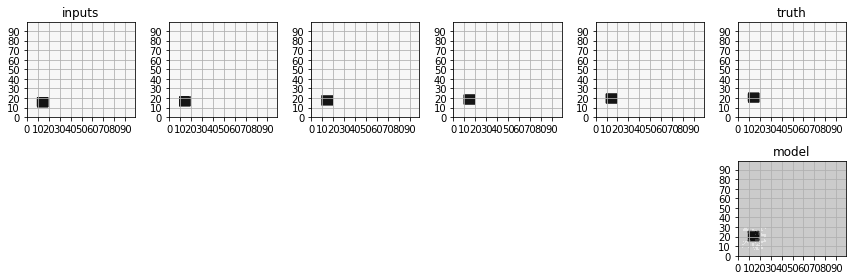

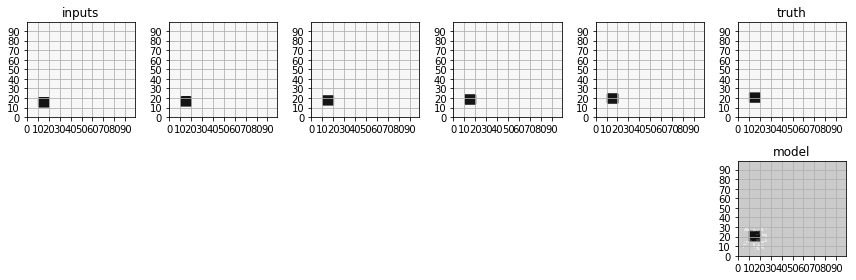

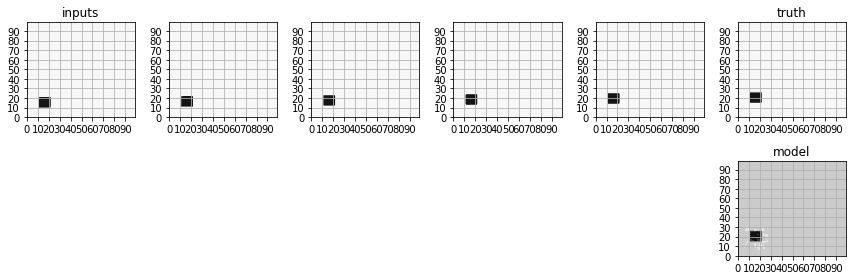

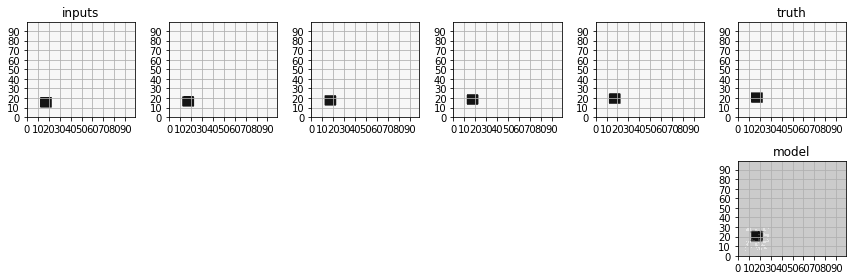

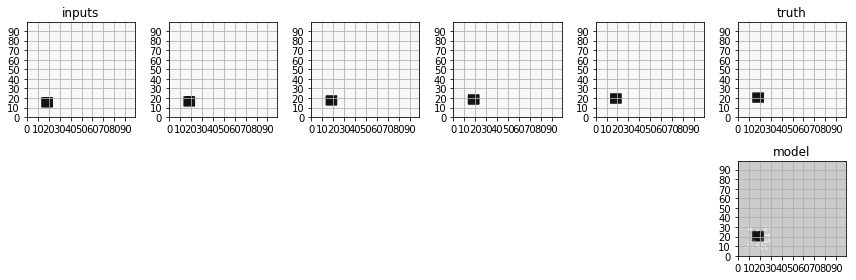

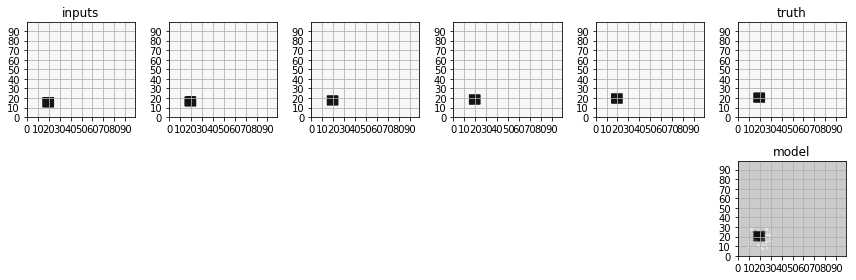

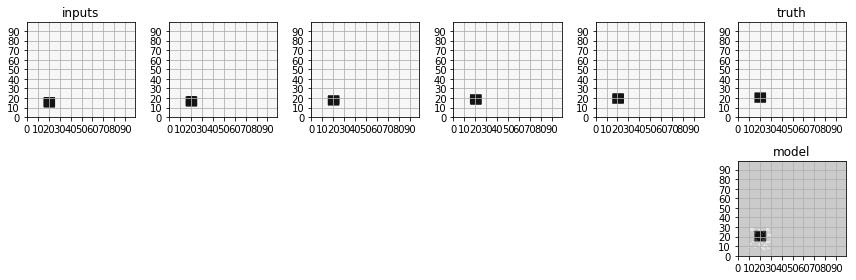

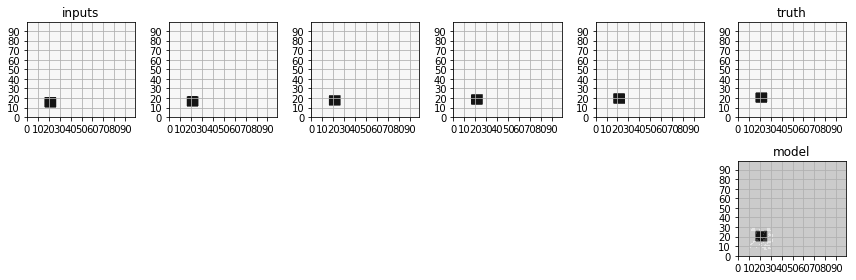

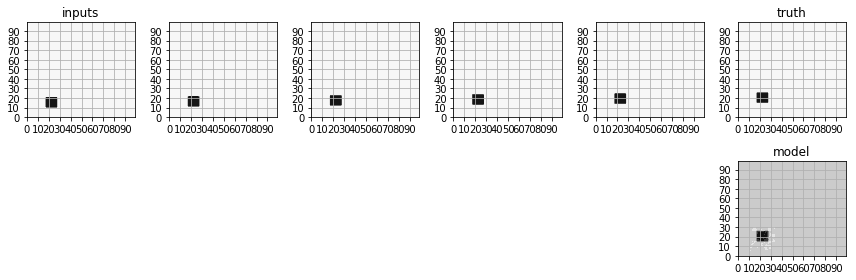

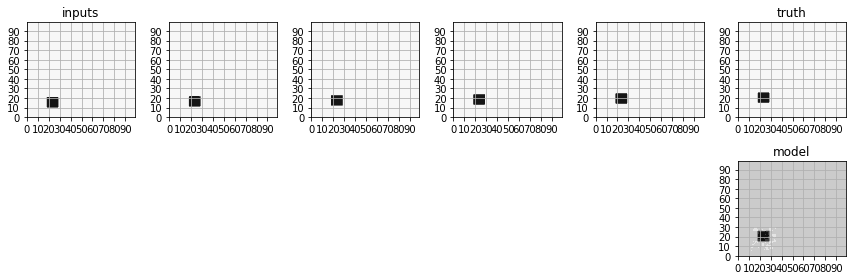

In [127]:
show_outputs(cnn, val_loader)